In [ ]:
%run preprocessing.ipynb

In [ ]:
file_path  = "model/attn.pth"

In [ ]:
%run temporal_preprocess.ipynb

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import math
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
print(top_50_features)

In [33]:
transformer_input

{-3.086626264365936: array([[-0.02624148506649588, -0.16565360732335718, 4.738637299186637,
         ..., -0.33348748598929434, Timestamp('2016-01-01 00:00:00'),
         -3.086626264365936],
        [-0.02624148506649588, -0.16565360733085963, 4.739244262861304,
         ..., -0.33348748598929434, Timestamp('2016-02-01 00:00:00'),
         -3.086626264365936],
        [-0.02624148506649588, -0.165653607337941, 4.739853113020522, ...,
         -0.33348748598929434, Timestamp('2016-03-01 00:00:00'),
         -3.086626264365936],
        ...,
        [-0.02624148506649588, -0.1656536074542412, 4.783446059925778,
         ..., -0.3334874859892945, Timestamp('2021-08-01 00:00:00'),
         -3.086626264365936],
        [-0.02624148506649588, -0.1656536074543977, 4.784178069206026,
         ..., -0.3334874859892945, Timestamp('2021-09-01 00:00:00'),
         -3.086626264365936],
        [-0.02624148506649588, -0.16565360745454535, 4.7849119229850094,
         ..., -0.3334874859892945, Times

In [34]:
date_encodings

{-3.086626264365936: Index([1451606400.0, 1454284800.0, 1456790400.0, 1459468800.0, 1462060800.0,
        1464739200.0, 1467331200.0, 1470009600.0, 1472688000.0, 1475280000.0,
        1477958400.0, 1480550400.0, 1483228800.0, 1485907200.0, 1488326400.0,
        1491004800.0, 1493596800.0, 1496275200.0, 1498867200.0, 1501545600.0,
        1504224000.0, 1506816000.0, 1509494400.0, 1512086400.0, 1514764800.0,
        1517443200.0, 1519862400.0, 1522540800.0, 1525132800.0, 1527811200.0,
        1530403200.0, 1533081600.0, 1535760000.0, 1538352000.0, 1541030400.0,
        1543622400.0, 1546300800.0, 1548979200.0, 1551398400.0, 1554076800.0,
        1556668800.0, 1559347200.0, 1561939200.0, 1564617600.0, 1567296000.0,
        1569888000.0, 1572566400.0, 1575158400.0, 1577836800.0, 1577836800.0,
        1580515200.0, 1580515200.0, 1583020800.0, 1583020800.0, 1585699200.0,
        1585699200.0, 1588291200.0, 1588291200.0, 1590969600.0, 1590969600.0,
        1593561600.0, 1593561600.0, 15962400

In [ ]:
class TransformerDataset(Dataset):
    def __init__(self, data, date_encodings):
        self.data = data
        self.date_encodings = date_encodings

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        gid = list(self.data.keys())[idx]
        features = np.array(self.data[gid][:, :-2], dtype=np.float32)  # Exclude the last two columns if last is target and second last is date
        target = np.array(self.data[gid][:, -1], dtype=np.float32)
        dates = self.date_encodings[gid]
        return torch.tensor(features), torch.tensor(dates), torch.tensor(target)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x, dates):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class TemporalTransformerEncoder(nn.Module):
    def __init__(self, input_size, d_model, nhead, num_layers, dim_feedforward=512, dropout=0.1):
        super(TemporalTransformerEncoder, self).__init__()
        self.input_embedding = nn.Linear(input_size, d_model // 2)
        self.pos_encoder = PositionalEncoding(d_model // 2, dropout=dropout)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model // 2, nhead=nhead // 2, dim_feedforward=dim_feedforward // 2, dropout=dropout, activation='gelu')
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.output_layer = nn.Linear(d_model // 2, 1)

    def forward(self, x, dates):
        x = self.input_embedding(x)
        x = self.pos_encoder(x, dates)
        x = self.transformer_encoder(x)
        output = self.output_layer(x)
        return output.squeeze(-1)

In [30]:
# Proper DataLoader initialization
dataset = TransformerDataset(transformer_input, date_encodings)
train_set, val_set = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
train_loader = DataLoader([dataset[i] for i in train_set], batch_size=64, shuffle=True)
val_loader = DataLoader([dataset[i] for i in val_set], batch_size=64, shuffle=False)

# Initialize the model
model = TemporalTransformerEncoder(input_size=len(top_50_features), d_model=12, nhead=4, num_layers=16)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

import matplotlib.pyplot as plt

# Additional metrics for performance evaluation
def r_squared(y_true, y_pred):
    ss_res = ((y_true - y_pred) ** 2).sum()
    ss_tot = ((y_true - y_true.mean()) ** 2).sum()
    r2 = 1 - ss_res / ss_tot
    return r2.item()

# Lists to store loss and metrics for visualization
train_losses = []
val_losses = []
val_r2_scores = []

# Adjust the training loop to include validation metrics
for epoch in range(10):
    model.train()
    train_loss = 0
    for x, dates, target in train_loader:
        optimizer.zero_grad()
        output = model(x, dates)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0
    total_r2 = 0
    with torch.no_grad():
        for x, dates, target in val_loader:
            output = model(x, dates)
            loss = criterion(output, target)
            val_loss += loss.item()
            total_r2 += r_squared(target, output)
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    avg_r2 = total_r2 / len(val_loader)
    val_r2_scores.append(avg_r2)

    # Save the model if the training loss meets certain condition
    if train_loss <= 0.4:
        print(f"Early Stoping at Epoch: {epoch+1}, Training Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val R^2: {avg_r2:.4f}") 
        torch.save(model.state_dict(), file_path)
        print(f"Model saved at {file_path}")
        break
    print(f'Epoch: {epoch+1}, Training Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val R^2: {avg_r2:.4f}')


Epoch: 1, Training Loss: 0.9217, Val Loss: 0.6394, Val R^2: 0.3655
Epoch: 2, Training Loss: 0.6574, Val Loss: 0.5051, Val R^2: 0.4971
Epoch: 3, Training Loss: 0.5564, Val Loss: 0.4255, Val R^2: 0.5753
Epoch: 4, Training Loss: 0.4923, Val Loss: 0.3686, Val R^2: 0.6314
Epoch: 5, Training Loss: 0.4504, Val Loss: 0.3389, Val R^2: 0.6621
Epoch: 6, Training Loss: 0.4144, Val Loss: 0.3111, Val R^2: 0.6892
Early Stoping at Epoch: 7, Training Loss: 0.3903, Val Loss: 0.2944, Val R^2: 0.7062
Model saved at model/attn.pth


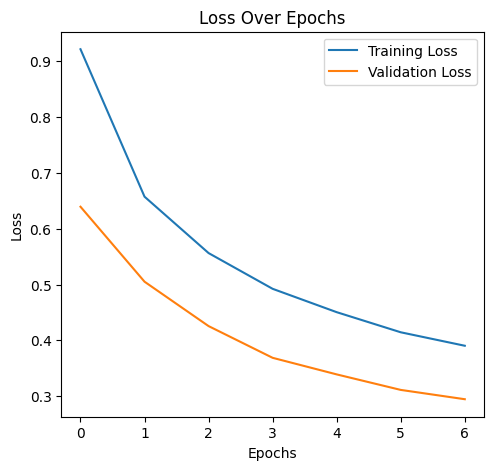

In [31]:
# Plotting training and validation loss over epochs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

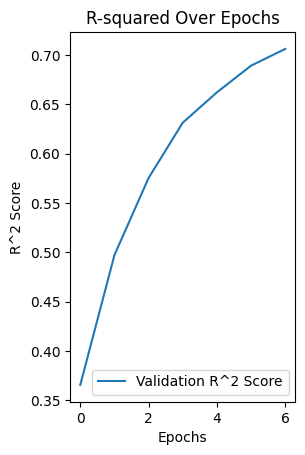

In [32]:
# Plotting R-squared values
plt.subplot(1, 2, 2)
plt.plot(val_r2_scores, label='Validation R^2 Score')
plt.title('R-squared Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('R^2 Score')
plt.legend()
plt.show()